In [2]:
from PIL import Image,ImageOps
import random
import os.path as osp
import os
import numpy as np
import math
import cv2
import glob
import multiprocessing
import re
import torch
import torch.nn as nn

import keras.callbacks as callbacks
import keras
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%matplotlib inline

Using TensorFlow backend.


## UNet with ResNet34 encoder (Pytorch)
<code>https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch/notebook\<code/>

In [5]:
from PIL import Image,ImageOps
import random
import os.path as osp
import os
import numpy as np
import math
import cv2
import glob
import multiprocessing
import re
import torch
import torch.nn as nn

import keras.callbacks as callbacks
import keras
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
Image.MAX_IMAGE_PIXELS=None

%matplotlib inline

Using TensorFlow backend.


In [6]:
import torch
import torch.nn as nn
from torchvision import models
train_mask_dir = "../DigestPath2019/train_mask" #create  train mask
train_dir = "../DigestPath2019/train"
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        #nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        #nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    # BasicBlock and BottleNeck block
    # have different output size
    # we use class attribute expansion
    # to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        # shortcut
        self.shortcut = nn.Sequential()

        # the shortcut output dimension is not the same with residual function
        # use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))



class ResNet(nn.Module):

    def __init__(self,in_channel,out_channel, block, num_block):
        super().__init__()
        #self.in_channels = in_channel
        self.outc = out_channel #不能加self.out_channel  不是很懂为啥 估计是变量优先级问题
        self.in_channels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size = 7, stride = 2, padding = 3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # we use a different inputsize than the original paper
        # so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        # self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.dconv_last=nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64,out_channel,1)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)# [stride, 1,1,1...]
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        print(x.shape)
        conv1 = self.conv1(x)
        temp=self.maxpool(conv1)
        print(temp.shape)
        print(self.conv2_x)
        conv2 = self.conv2_x(temp)
        conv3 = self.conv3_x(conv2)
        conv4 = self.conv4_x(conv3)
        bottle = self.conv5_x(conv4)
        # output = self.avg_pool(output)
        # output = output.view(output.size(0), -1)
        # output = self.fc(output)
        x = self.upsample(bottle)
        # print(x.shape)
        # print(conv4.shape)
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        # print(x.shape)
        # print(conv3.shape)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        # print(x.shape)
        # print(conv2.shape)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up1(x)
        x=self.upsample(x)
        # print(x.shape)
        # print(conv1.shape)
        x=torch.cat([x,conv1],dim=1)
        out=self.dconv_last(x)

        return out

    def load_pretrained_weights(self):
         # 导入自己模型的参数
        model_dict=self.state_dict()
        
        resnet34_weights = models.resnet34(True).state_dict()
        count_res = 0
        count_my = 0

        reskeys = list(resnet34_weights.keys())
        mykeys = list(model_dict.keys())
        # print(self)  自己网络的结构
        # print(models.resnet34())   resnet结构
        # print(reskeys)
        # print(mykeys)

        corresp_map = []
        while (True):              # 后缀相同的放入list
            reskey = reskeys[count_res]
            mykey = mykeys[count_my]

            if "fc" in reskey:
                break

            while reskey.split(".")[-1] not in mykey:
                count_my += 1
                mykey = mykeys[count_my]

            corresp_map.append([reskey, mykey])
            count_res += 1
            count_my += 1

        for k_res, k_my in corresp_map:
            model_dict[k_my]=resnet34_weights[k_res]

        try:
            self.load_state_dict(model_dict)
            print("Loaded resnet34 weights in mynet !")
        except:
            print("Error resnet34 weights in mynet !")
            raise


def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])


def resnet34(in_channel,out_channel,pretrain=True):
    """ return a ResNet 34 object
    """
    model=ResNet(in_channel,out_channel,BasicBlock, [3, 4, 6, 3])
    if pretrain:
        model.load_pretrained_weights()
    return model


def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])


def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])


def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

if __name__ == '__main__':
    net = resnet34(3, 4, False) # out_channel = 4  4分类问题
    #print(net)
    x = torch.rand((1, 3, 512, 512)) #N，C, H, W
    print(net.forward(x).shape)


torch.Size([1, 3, 512, 512])
torch.Size([1, 64, 128, 128])
Sequential(
  (0): BasicBlock(
    (residual_function): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (residual_function): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
import argparse
import logging
import os
import sys
import model.model as model
from eval import eval_net
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from PIL import Image
from tqdm import tqdm
import glob
import cv2
Image.MAX_IMAGE_PIXELS=None
%matplotlib inline

'''
from eval import eval_net
from unet import UNet
from utils.dataset import BasicDataset
'''
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, Dataset
def show_img(img):
    plt.figure(figsize=(18,15))
    # unnormalize
    #npimg=Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.imshow(img)
    plt.show()
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, preprocess=None,scale=0.1, mask_suffix='_mask'):      
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.preprocess= preprocess
        #self.scale = scale
        self.scale = 512
        self.mask_suffix = mask_suffix

        self.ids = [os.path.splitext(file)[0] for file in os.listdir(imgs_dir)
                    if not file.startswith('.')]   # get prefix or so-called id
        logging.info(f'Creating dataset with {len(self.ids)} examples')
        #print("image_directory:{}  with {} files.\nmask_dir:{}".format(imgs_dir,len(self.ids),masks_dir))

    def __len__(self):
        return len(self.ids)

    @classmethod
    def process(cls, pil_img):
        #w, h = pil_img.size
        img = np.array(pil_img)
        # unnormalize
        opencvImage = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        print("cv2 show by process")
        cv2.imshow("sss",opencvImage)
        
        return opencvImage
        #newW, newH = int(scale * w), int(scale * h)
        #assert w > 0 and h > 0, 'Scale is too small
        #pil_img = pil_img.resize((size, size))

        ''' img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans'''

    def __getitem__(self, i):
        idx = self.ids[i]
        temp = os.path.join(self.masks_dir,idx+self.mask_suffix+'.*')
        mask_file = glob.glob(temp)

        img_file = glob.glob(os.path.join(self.imgs_dir , idx + '.*'))

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        #print(mask_file[0])
        img = Image.open(img_file[0])
        # HWC to CHW
        img = self.process(img)
        show_img(img)
        #print(img)
        mask =self.process(mask)
        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'
        #print(type(mask)))
        print(type(img))
        transformed = self.preprocess(image=img,mask=mask)
        img= transformed['image']
        mask= transformed['mask']
        print("show tranformed")
        show_img(img)
        show_img(mask)        
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }


../Colonoscopy_tissue_segment_dataset/train_mask/18-14278B_2019-05-08 02_13_11-lv1-17874-10382-3996-6342_mask.jpg
cv2 show by process


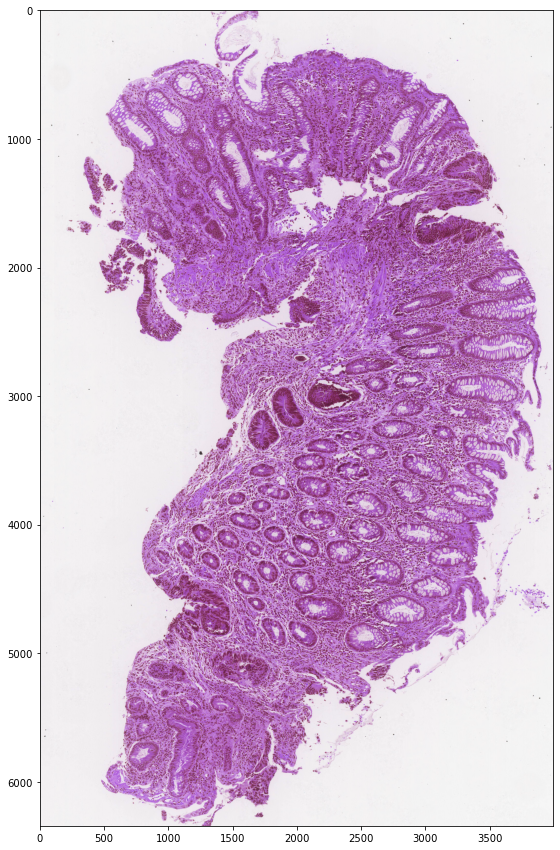

cv2 show by process
<class 'numpy.ndarray'>
show tranformed


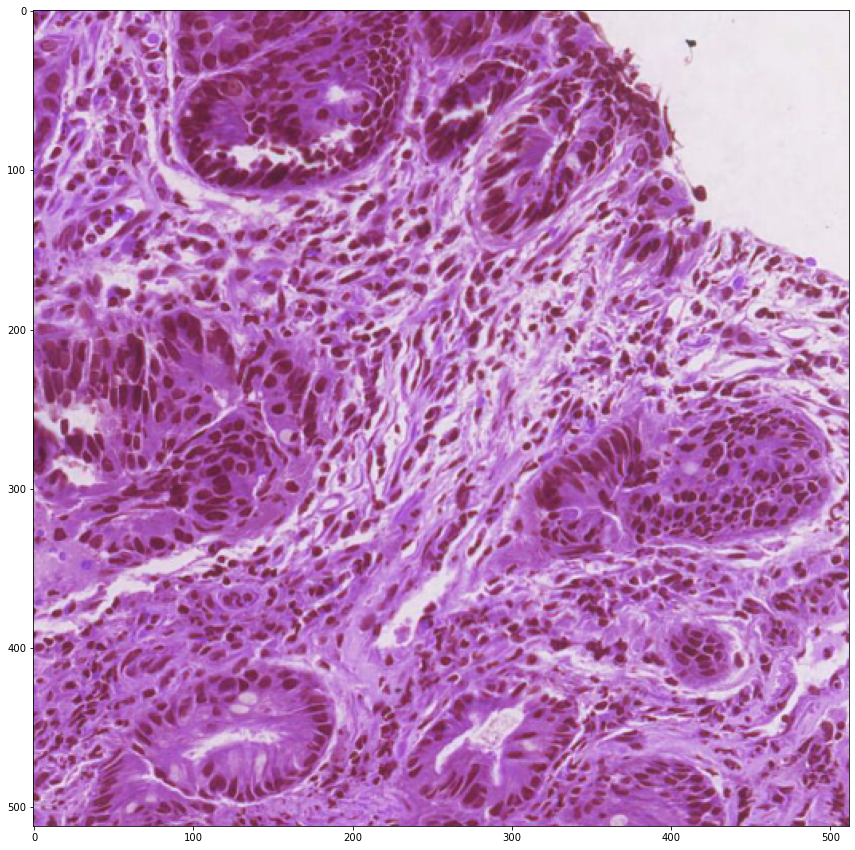

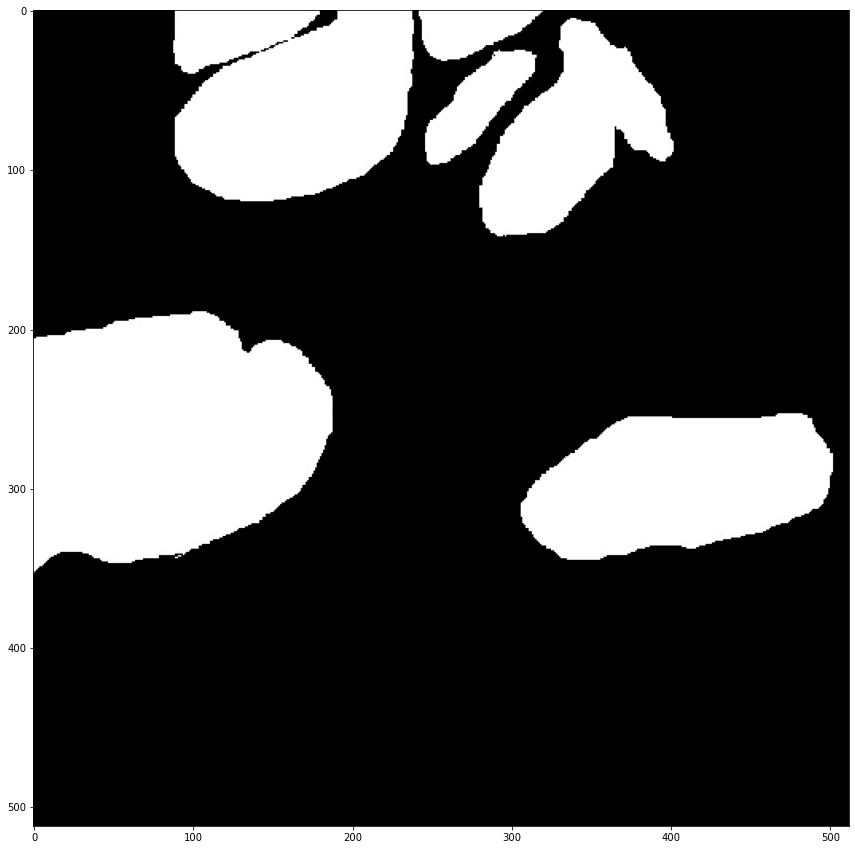

transformed:tensor([[[176., 103., 173.],
         [180., 104., 188.],
         [178., 111., 204.],
         ...,
         [242., 235., 242.],
         [242., 235., 242.],
         [241., 234., 241.]],

        [[140.,  70., 132.],
         [123.,  62., 115.],
         [117.,  65., 135.],
         ...,
         [241., 235., 241.],
         [242., 235., 242.],
         [241., 234., 241.]],

        [[135.,  54., 103.],
         [131.,  43.,  77.],
         [128.,  49.,  91.],
         ...,
         [240., 236., 240.],
         [240., 236., 241.],
         [239., 235., 240.]],

        ...,

        [[156.,  90., 172.],
         [157.,  77., 168.],
         [158.,  79., 174.],
         ...,
         [120.,  52.,  74.],
         [130.,  60.,  87.],
         [134.,  64., 102.]],

        [[183., 114., 202.],
         [171.,  92., 196.],
         [168.,  89., 195.],
         ...,
         [111.,  45.,  79.],
         [112.,  44.,  77.],
         [128.,  61.,  97.]],

        [[186., 111., 19

AttributeError: 'Tensor' object has no attribute 'astype'

In [175]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
size = 512
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness()
    ], p=0.3),
    OneOf([
        ElasticTransform(alpha = 120, sigma=120*0.05,alpha_affine = 12*0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit = 2, shift_limit = 0.5)
    ], p=0.3),
    RandomSizedCrop(min_max_height=(512,1024),height = size, width =size,p=1),
    ToFloat(max_value=1)
], p =1)

AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)
def show_img(img):
    plt.figure(figsize=(18,15))
    # unnormalize
    #npimg=Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.imshow(img.astype(int))
    plt.show()


train_mask_dir = "../Colonoscopy_tissue_segment_dataset/train_mask" #create  train mask
train_dir = "../Colonoscopy_tissue_segment_dataset/train" # create train data
val_mask_dir = "../Colonoscopy_tissue_segment_dataset/val_mask"
val_dir = "../Colonoscopy_tissue_segment_dataset/val"

dataset = BasicDataset(train_dir, train_mask_dir,AUGMENTATIONS_TRAIN)
img_set = dataset.__getitem__(199)
#show_img(img_set['image'])
print("transformed:{}".format(img_set['image']))
show_img(img_set['image'])


In [ ]:
img_url="../Colonoscopy_tissue_segment_dataset/train/1902160001_2019-06-11 12_36_32-lv1-39045-16016-3312-4096.jpg"
image = Image.open(img_url)

img = np.array(image)
# unnormalize
print(img)
show_img(img)

opencvImage = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print("cv2 show by process")
cv2.imshow("sss",opencvImage)
print(opencvImage)
opencvImage=AUGMENTATIONS_TRAIN(image=opencvImage)['image']
print(opencvImage)

show_img(opencvImage.astype(np.int))
